In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pickle

from qiskit import *
from qiskit.visualization import plot_histogram

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa_plus

matplotlib.rc('xtick', labelsize=18)     
matplotlib.rc('ytick', labelsize=18)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
test_graphs = glob.glob('benchmark_graphs/N10_p50_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

50


benchmark_graphs/N10_p50_graphs/G41.txt
Optimal: ('0011000001', 3)


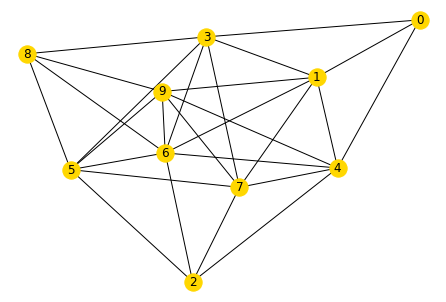

In [3]:
graph = test_graphs[40]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [10]:
def construct_qaoa_plus(P, G, params, barriers=False, measure=False):
    assert (len(params) == 2*P), "Number of parameters should be 2P"
    
    nq = len(G.nodes())
    circ = QuantumCircuit(nq, name='q')
    
    # Initial state
    circ.h(range(nq))
    
    gammas = [param for i, param in enumerate(params) if i % 2 == 0]
    betas  = [param for i, param in enumerate(params) if i % 2 == 1]
    for i in range(P):
        # Phase Separator Unitary
        for edge in G.edges():
            q_i, q_j = edge
            circ.rz(gammas[i] / 2, [q_i, q_j])
            circ.cx(q_i, q_j)
            circ.rz(-1 * gammas[i] / 2, q_j)
            circ.cx(q_i, q_j)
            if barriers:
                circ.barrier()
    
        # Mixing Unitary
        for q_i in range(nq):
            circ.rx(-2 * betas[i], q_i)
    
    if measure:
        circ.measure_all()
    
    return circ

In [11]:
def expectation_value(counts, G, Lambda):
    total_shots = sum(counts.values())
    energy = 0
    for bitstr, count in counts.items():
        temp_energy = hamming_weight(bitstr)
        for edge in G.edges():
            q_i, q_j = edge
            rev_bitstr = list(reversed(bitstr))
            if rev_bitstr[q_i] == '1' and rev_bitstr[q_j] == '1':
                temp_energy += -1 * Lambda
            
        energy += count * temp_energy / total_shots
        
    return energy

In [12]:
P = 1
params = [1 for i in range(2*P)]
qaoa_circ = construct_qaoa_plus(P, G, params, barriers=True)
qaoa_circ.draw(fold=-1)

┌───┐┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░ ┌────────┐
q_0: ┤ H ├┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░─┤ RX(-2) ├
     ├───┤└─────────┘  │                │   ░ └─────────┘  │                │   ░ └─────────┘  │                │   ░ └─────────┘  │                │   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░ ┌─────────┐                       ░ ├────────┤
q_1: ┤ H ├─────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░─┤ RZ(0.5) ├──■────────────────■───░─┤ RX(-2) ├
     ├───┤┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐ ░              │                │   ░              │                │   ░              │                │   ░ ┌─────────┐                       ░ ┌─────────┐                       ░                                   ░                                   ░                                   ░                                   ░ └─────────┘  │                │   ░ ├────────┤
q_2: ┤ H ├┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░──────────────┼────────────────┼───░─┤ RX(-2) ├
     ├───┤└─────────┘└───┘└──────────┘└───┘ ░              │                │   ░              │                │   ░              │                │   ░ └─────────┘  │                │   ░ └─────────┘  │                │   ░                                   ░                                   ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░              │                │   ░ ├────────┤
q_3: ┤ H ├──────────────────────────────────░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░──────────────┼────────────────┼───░───────────────────────────────────░───────────────────────────────────░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░─┤ RX(-2) ├
     ├───┤                                  ░ ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐ ░              │                │   ░              │                │   ░ ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐ ░              │                │   ░ ┌─────────┐                       ░ ┌─────────┐                       ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░              │                │   ░ ├────────┤
q_4: ┤ H ├──────────────────────────────────░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░──────────────┼────────────────┼───░─┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░─┤ RZ(0.5) ├──■────────────

In [13]:
def top_strs(counts, G, top=5):
    total_shots = sum(counts.values())
    probs = [(bitstr, counts[bitstr] / total_shots) for bitstr in counts.keys()]
    probs = sorted(probs, key=lambda p: p[1], reverse=True)
    
    for i in range(top):
        print('{} -> {:.4f}%, Is MIS? {}'.format(probs[i][0], probs[i][1] * 100,
                                                 is_indset(probs[i][0], G)))

In [14]:
def f(params, Lambda):
    circ = construct_qaoa_plus(P, G, params, measure=True)
    
    result = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
    counts = result.get_counts(circ)
    
    return -1 * expectation_value(counts, G, Lambda)

In [17]:
Lambda = 0.5
P = 3
init_params = [0] * 2 * P
out = scipy.optimize.minimize(f, x0=init_params, args=(Lambda), method='COBYLA')
print(out)

     fun: -3.4512939453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 97
  status: 1
 success: True
       x: array([-0.5066914 ,  0.34942585,  1.17912065,  1.04400981,  1.28602738,
        0.51519881])


In [6]:
circ = construct_qaoa_plus(P, G, params=out['x'], barriers=False, measure=True)
result = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
counts = result.get_counts(circ)
print('Optimal MIS:', brute_force_search(G))
top_strs(counts, G, top=8)
print('Expected energy:', expectation_value(counts, G, Lambda))
plot_histogram(counts, bar_labels=False)

NameError: name 'construct_qaoa_plus' is not defined

In [9]:
P = 3
Lambda = 1.5
out = qaoa_plus.solve_mis(P, G, Lambda)
print(out)

ratio = qaoa_plus.get_approximation_ratio(out, P, G)
print('ratio:', ratio)

     fun: -1.27447509765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 74
  status: 1
 success: True
       x: array([ 0.30084504,  1.13863142,  0.95414804, -0.72450201, -0.07954492,
       -0.7794406 ])
ratio: 0.3388671875


In [10]:
np.arange(0.1,1.6,0.2)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5])

In [13]:
P = 3
ratios = []
ranks = []
Lambdas = [0.1, 0.5, 0.75, 1, 1.5, 2]
for Lambda in Lambdas:
    out = qaoa_plus.solve_mis(P, G, Lambda)
    exp_val = -1 * out['fun']
    opt_val = brute_force_search(G)[1]
    ranked_probs = qaoa_plus.get_ranked_probs(P, G, out['x'])
    for i, v in enumerate(ranked_probs):
        if v[2]:
            rank = i+1
            prob = v[1]
            break
            
    ratios.append(exp_val/opt_val)
    ranks.append(prob * 100)
    
    print(Lambda, exp_val/opt_val, rank)

0.1 2.28926188151042 220
0.5 0.8227335611979166 1
0.75 0.4631144205729167 1
1 0.5032552083333334 1
1.5 0.37628173828125 1
2 -0.16259765625 1


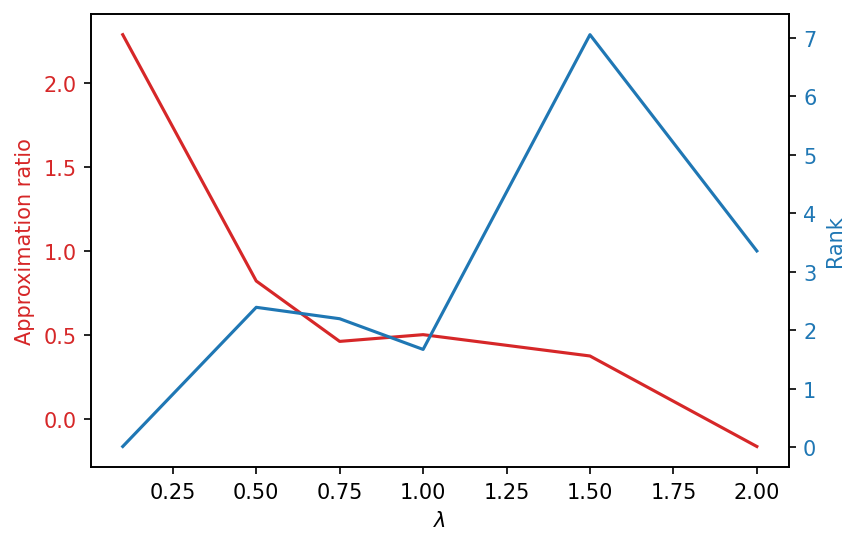

In [14]:
fig, ax1 = plt.subplots(dpi=150)

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Approximation ratio', color=color)
ax1.plot(Lambdas, ratios, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rank', color=color)
ax2.plot(Lambdas, ranks, color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [36]:
np.arange(0.1, 10, 0.7)

array([0.1, 0.8, 1.5, 2.2, 2.9, 3.6, 4.3, 5. , 5.7, 6.4, 7.1, 7.8, 8.5,
       9.2, 9.9])

In [160]:
def load_plus_data(graph_fn):
    data = {'graph':graph_fn, 'plus':{}, 'ansatz':{}}
    
    # Load the QAOA+ data
    all_Ps = glob.glob('benchmark_results/QAOA+*')
    for alg in all_Ps:
        data_array = []
        pval = alg.split('_')[-2]
        all_graphs = glob.glob(alg+'/'+graph_fn+'/*')
        print(alg, pval, len(all_graphs))
        for graphname in all_graphs:
            #print(graphname)
            picklefiles = glob.glob(graphname+'/*')
            for picklefile in picklefiles:
                pickle_array = []
                with open(picklefile, 'rb') as pf:
                    dat = pickle.load(pf)
                    for d in dat:
                        d_array = [d['lambda'], d['ratio'], d['rank'], d['prob']]
                        pickle_array.append(d_array)
                data_array.append(pickle_array)
                
        data_array = np.array(data_array)
        data['plus'][pval] = [np.mean(data_array, axis=0), np.std(data_array, axis=0),
                              np.max(data_array, axis=0),  np.min(data_array, axis=0)]
        
    # Load the QAO-Ansatz data
    all_Ps = glob.glob('benchmark_results/qaoa_P*')
    for alg in all_Ps:
        data_array = []
        pval = alg.split('_')[-2]
        all_graphs = glob.glob(alg+'/'+graph_fn+'/*')
        print(alg, pval, len(all_graphs))
        
        for graphname in all_graphs:
            picklefiles = glob.glob(graphname+'/*')
            rep_ratios = []
            G = graph_from_file('benchmark_graphs/'+'/'.join(graphname.split('/')[-2:])+'.txt')
            opt_mis = brute_force_search(G)[1]
            #print(graphname)
        
            for picklefile in picklefiles:
                with open(picklefile, 'rb') as pf:
                    dat = pickle.load(pf)
                    soln = dat['out'][0]
                    rep_ratios.append(hamming_weight(soln) / opt_mis)
            data_array.append(np.mean(rep_ratios))
        
        data_array = np.array(data_array)
        data['ansatz'][pval] = [np.mean(data_array), np.std(data_array),
                                np.max(data_array),  np.min(data_array)]
    
    
    return data

In [169]:
def plot_plus_data(plus_data, colors, markers, show=True, save=None):
    fig, ax1 = plt.subplots(dpi=150)
    ax2 = ax1.twinx()
    
    # Plot QAOA+ data
    for pval, color, marker in zip(plus_data['plus'].keys(), colors, markers):
        means, stds, maxs, mins = plus_data['plus'][pval]
        print(means[:,0])
       
        ax1.errorbar(means[:,0], means[:,1], color=color, fmt='-'+marker, label='QAOA+, '+pval, ms=4, lw=1)
        ax2.errorbar(means[:,0], means[:,3], color=color, fmt=':'+marker, label='QAOA+, '+pval, ms=4, lw=1)
        
    # Plot QAO-Ansatz data
    for pval, c in zip(plus_data['ansatz'].keys(), ['forestgreen', 'limegreen', 'seagreen']):
        qao_dat = plus_data['ansatz'][pval]
        ax1.axhline(y=qao_dat[0], label='QAO-Ansatz, '+pval, lw=1, ls='-.', color=c)
        
    ax1.set_title(plus_data['graph'])
    ax1.set_xlabel(r'$\lambda$')
    ax1.set_ylabel('Approximation ratio')
    ax2.set_ylabel('Probability of the most likely IS (%)')    
    ax1.legend()
    
    if not save is None:
        plt.savefig(save)
    
    if show:
        plt.show()
        
    plt.close()

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


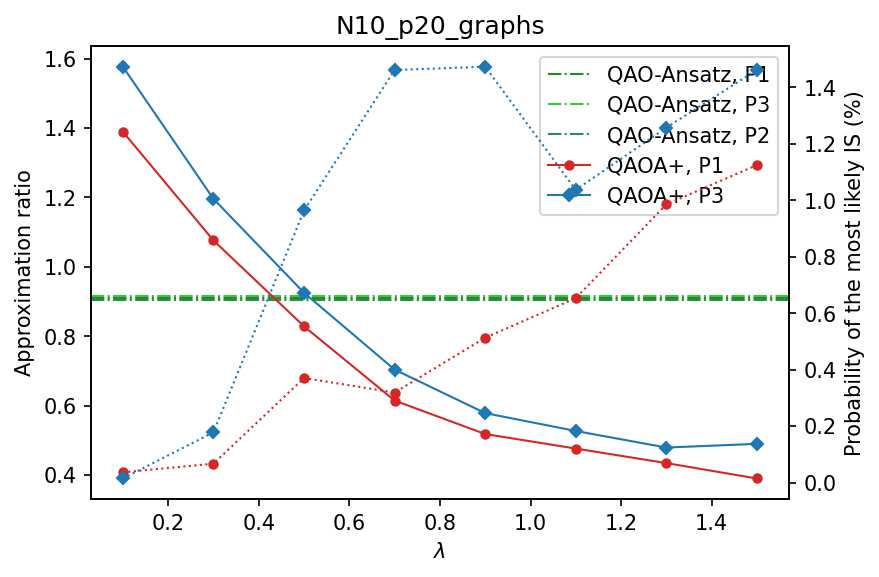

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


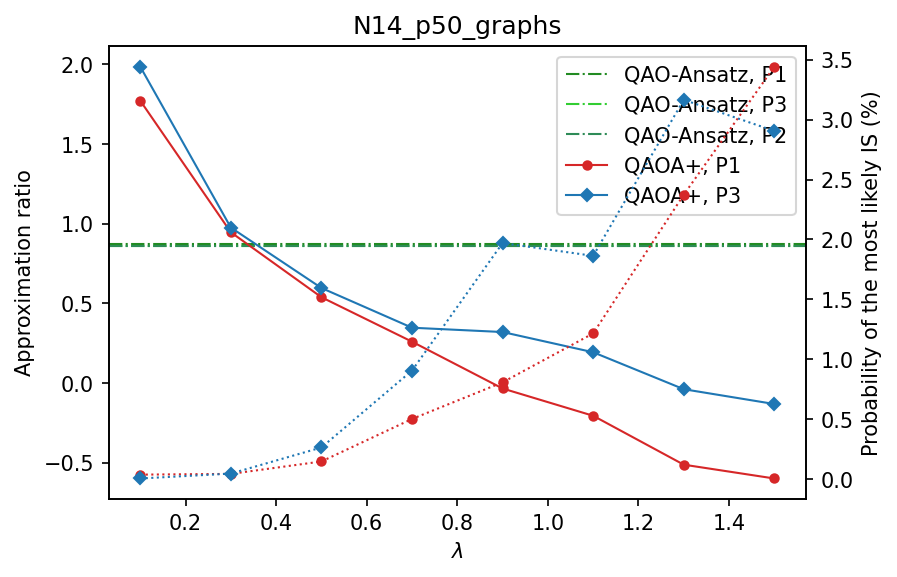

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


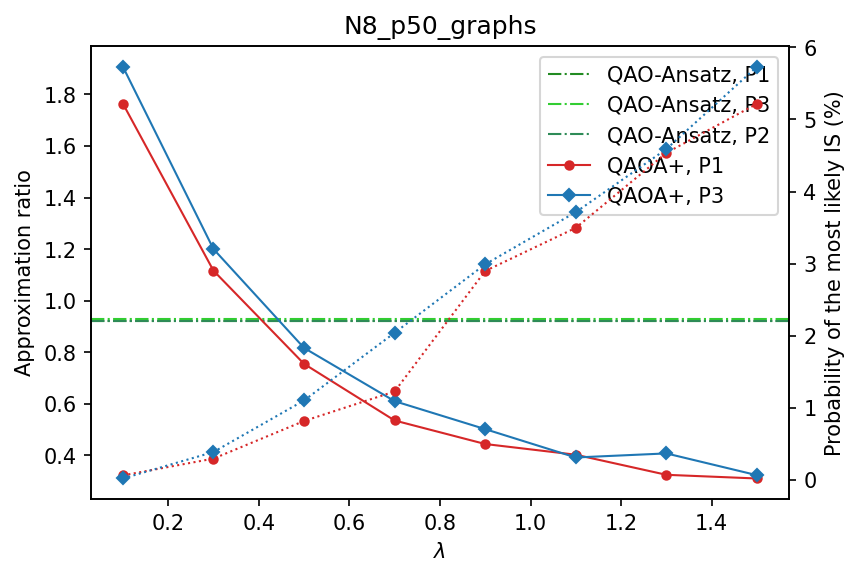

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


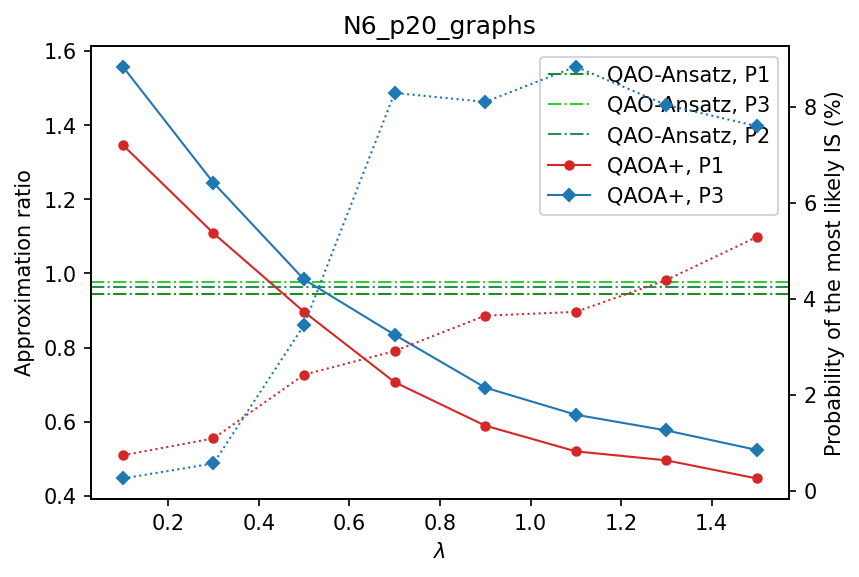

benchmark_results/QAOA+_P1_qasm P1 8
benchmark_results/QAOA+_P3_qasm P3 2
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 45
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


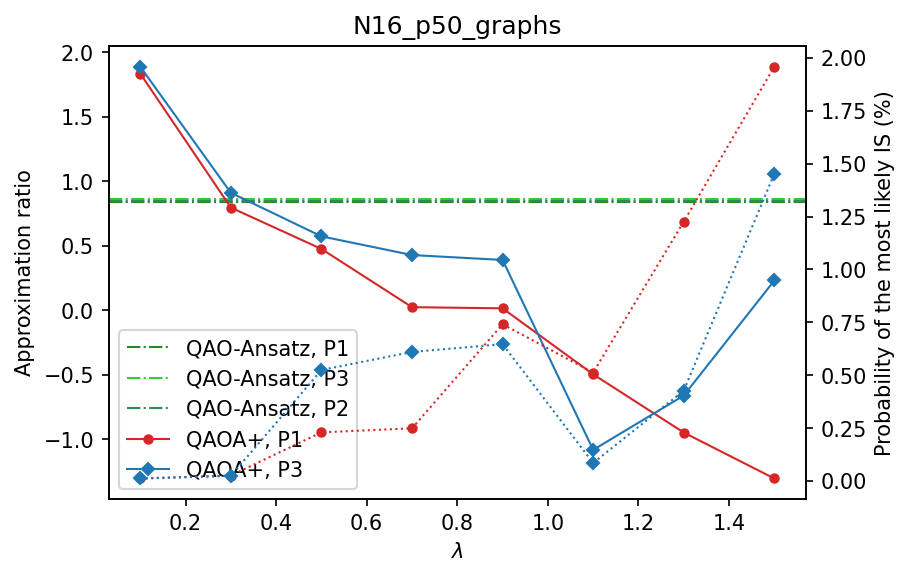

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


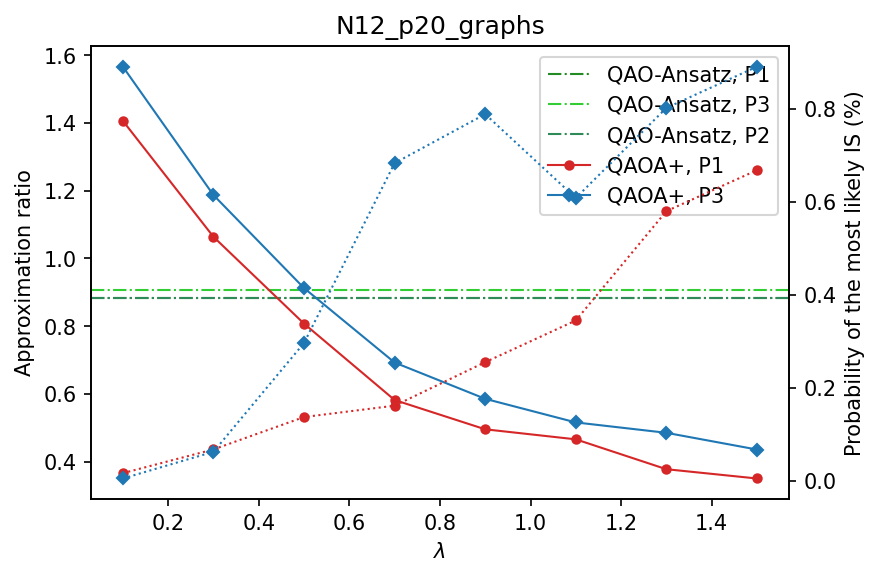

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


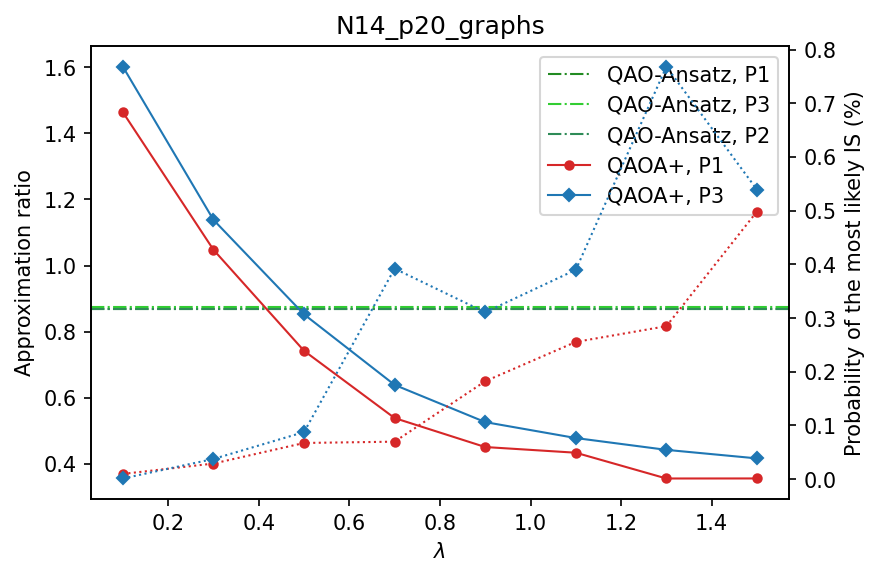

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


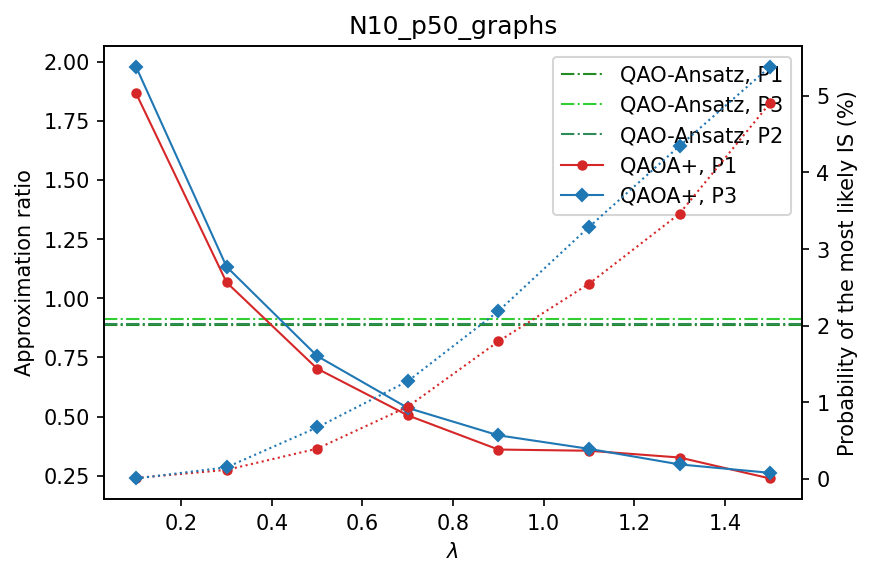

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


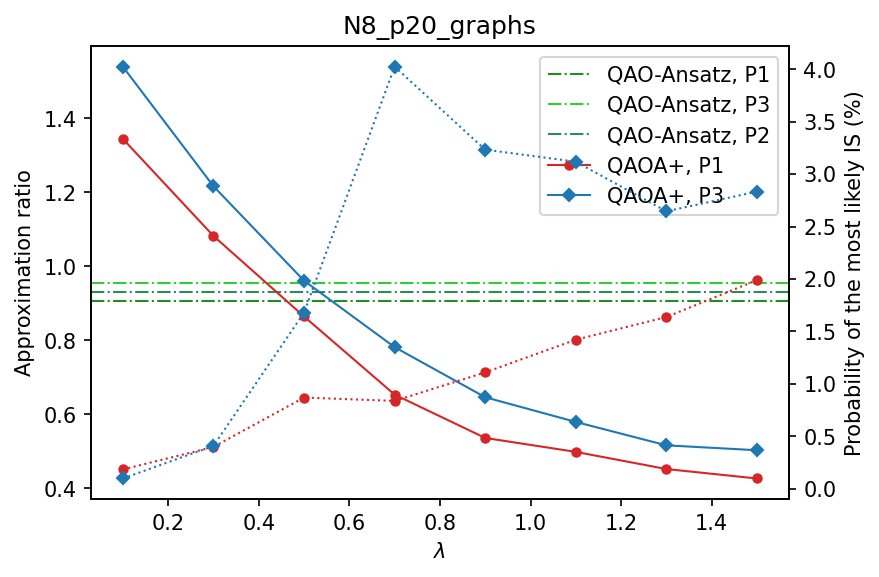

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


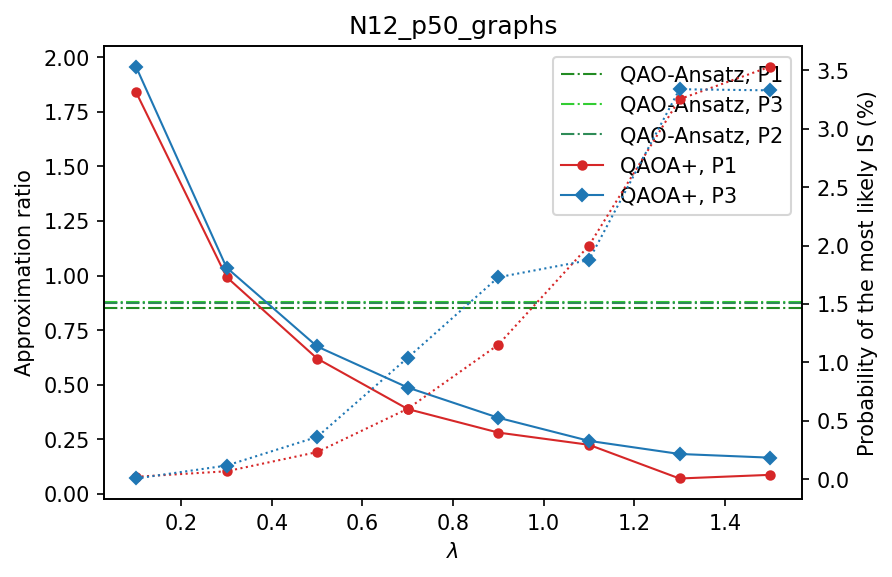

benchmark_results/QAOA+_P1_qasm P1 18
benchmark_results/QAOA+_P3_qasm P3 4
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


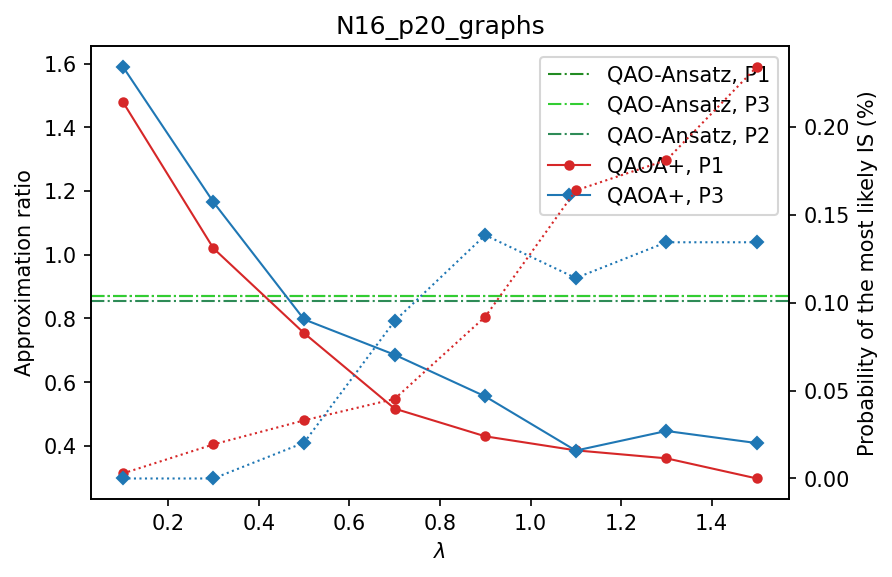

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


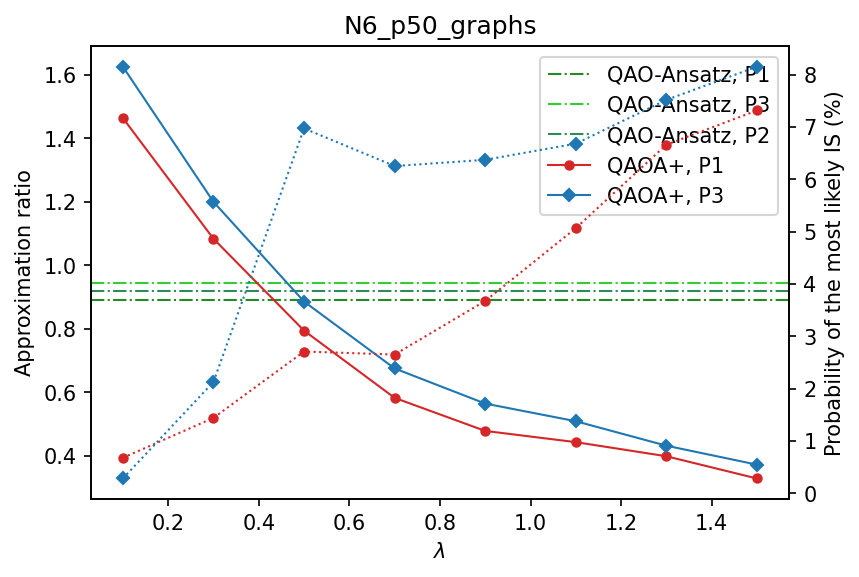

In [170]:
graphs = glob.glob('benchmark_results/QAOA+_P1_qasm/*')
for graph in graphs:
    graph = graph.split('/')[-1]
    plus_data = load_plus_data(graph)
    plot_plus_data(plus_data, ['tab:red', 'tab:blue'], ['o', 'D'], show=True, save=None)

In [185]:
def plot_comp_fig(fig_data, savestr=None, show=True):
    num_plots = len(fig_data)
    fig, ax = plt.subplots(dpi=150, figsize=[18,9], nrows=2, ncols=int(num_plots/2), sharey='row')
    
    for i, dat in enumerate(fig_data):
        ax1 = ax[i // int(num_plots / 2), i % int(num_plots / 2)]
        ax2 = ax1.twinx()
        
        name, graph, plus_data = dat
        print(name)
    
        # Plot QAOA+ data
        colors = ['tab:red', 'tab:blue']
        markers = ['o', 'D']
        for pval, color, marker in zip(plus_data['plus'].keys(), colors, markers):
            means, stds, maxs, mins = plus_data['plus'][pval]

            ax1.errorbar(means[:,0], means[:,1], color=color, fmt='-'+marker, label='QAOA+, '+pval, ms=4, lw=1)
            ax2.errorbar(means[:,0], means[:,3], color=color, fmt=':'+marker, label='QAOA+, '+pval, ms=4, lw=1)

        # Plot QAO-Ansatz data
        for pval, c in zip(plus_data['ansatz'].keys(), ['forestgreen', 'limegreen', 'seagreen']):
            qao_dat = plus_data['ansatz'][pval]
            ax1.axhline(y=qao_dat[0], label='QAO-Ansatz, '+pval, lw=1, ls='-.', color=c)

        if i % int(num_plots / 2) == int(num_plots/2)-1:
            ax2.set_ylabel('Probability of the most likely IS (%)', fontsize=18) 
        ax1.set_title(name, fontsize=18)
    
    ax[1,0].legend(fontsize=16, loc='lower right')
    for i in [0,1]:
        ax[i,0].set_ylabel('Approximation Ratio', fontsize=18)
    for i in [0,1,2]:
        ax[1,i].set_xlabel(r'$\lambda$', fontsize=18)
    plt.tight_layout()
    
    if not savestr is None:
        plt.savefig(savestr)
        
    if show:
        plt.show()

    plt.close()

In [171]:
# Plotting paper figure
graphs = ['N8_p20_graphs', 'N12_p20_graphs', 'N16_p20_graphs',
          'N8_p50_graphs', 'N12_p50_graphs', 'N16_p50_graphs']

figure_data = []
for graph in graphs:
    name = 'Avg Erdos-Renyi (N={}, p={}%)'.format(graph.split('_')[0].strip('N'),
                                                  graph.split('_')[1].strip('p'))
    
    data = load_plus_data(graph)
    
    figure_data.append((name, graph, data))

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
benchmark_results/QAOA+_P1_qasm P1 18
benchmark_results/QAOA+_P3_qasm P3 4
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
benchmark_results/QAOA+_P1_qasm P1 8
benchmark_results/QAOA+_P3_qa

Avg Erdos-Renyi (N=8, p=20%)
Avg Erdos-Renyi (N=12, p=20%)
Avg Erdos-Renyi (N=16, p=20%)
Avg Erdos-Renyi (N=8, p=50%)
Avg Erdos-Renyi (N=12, p=50%)
Avg Erdos-Renyi (N=16, p=50%)


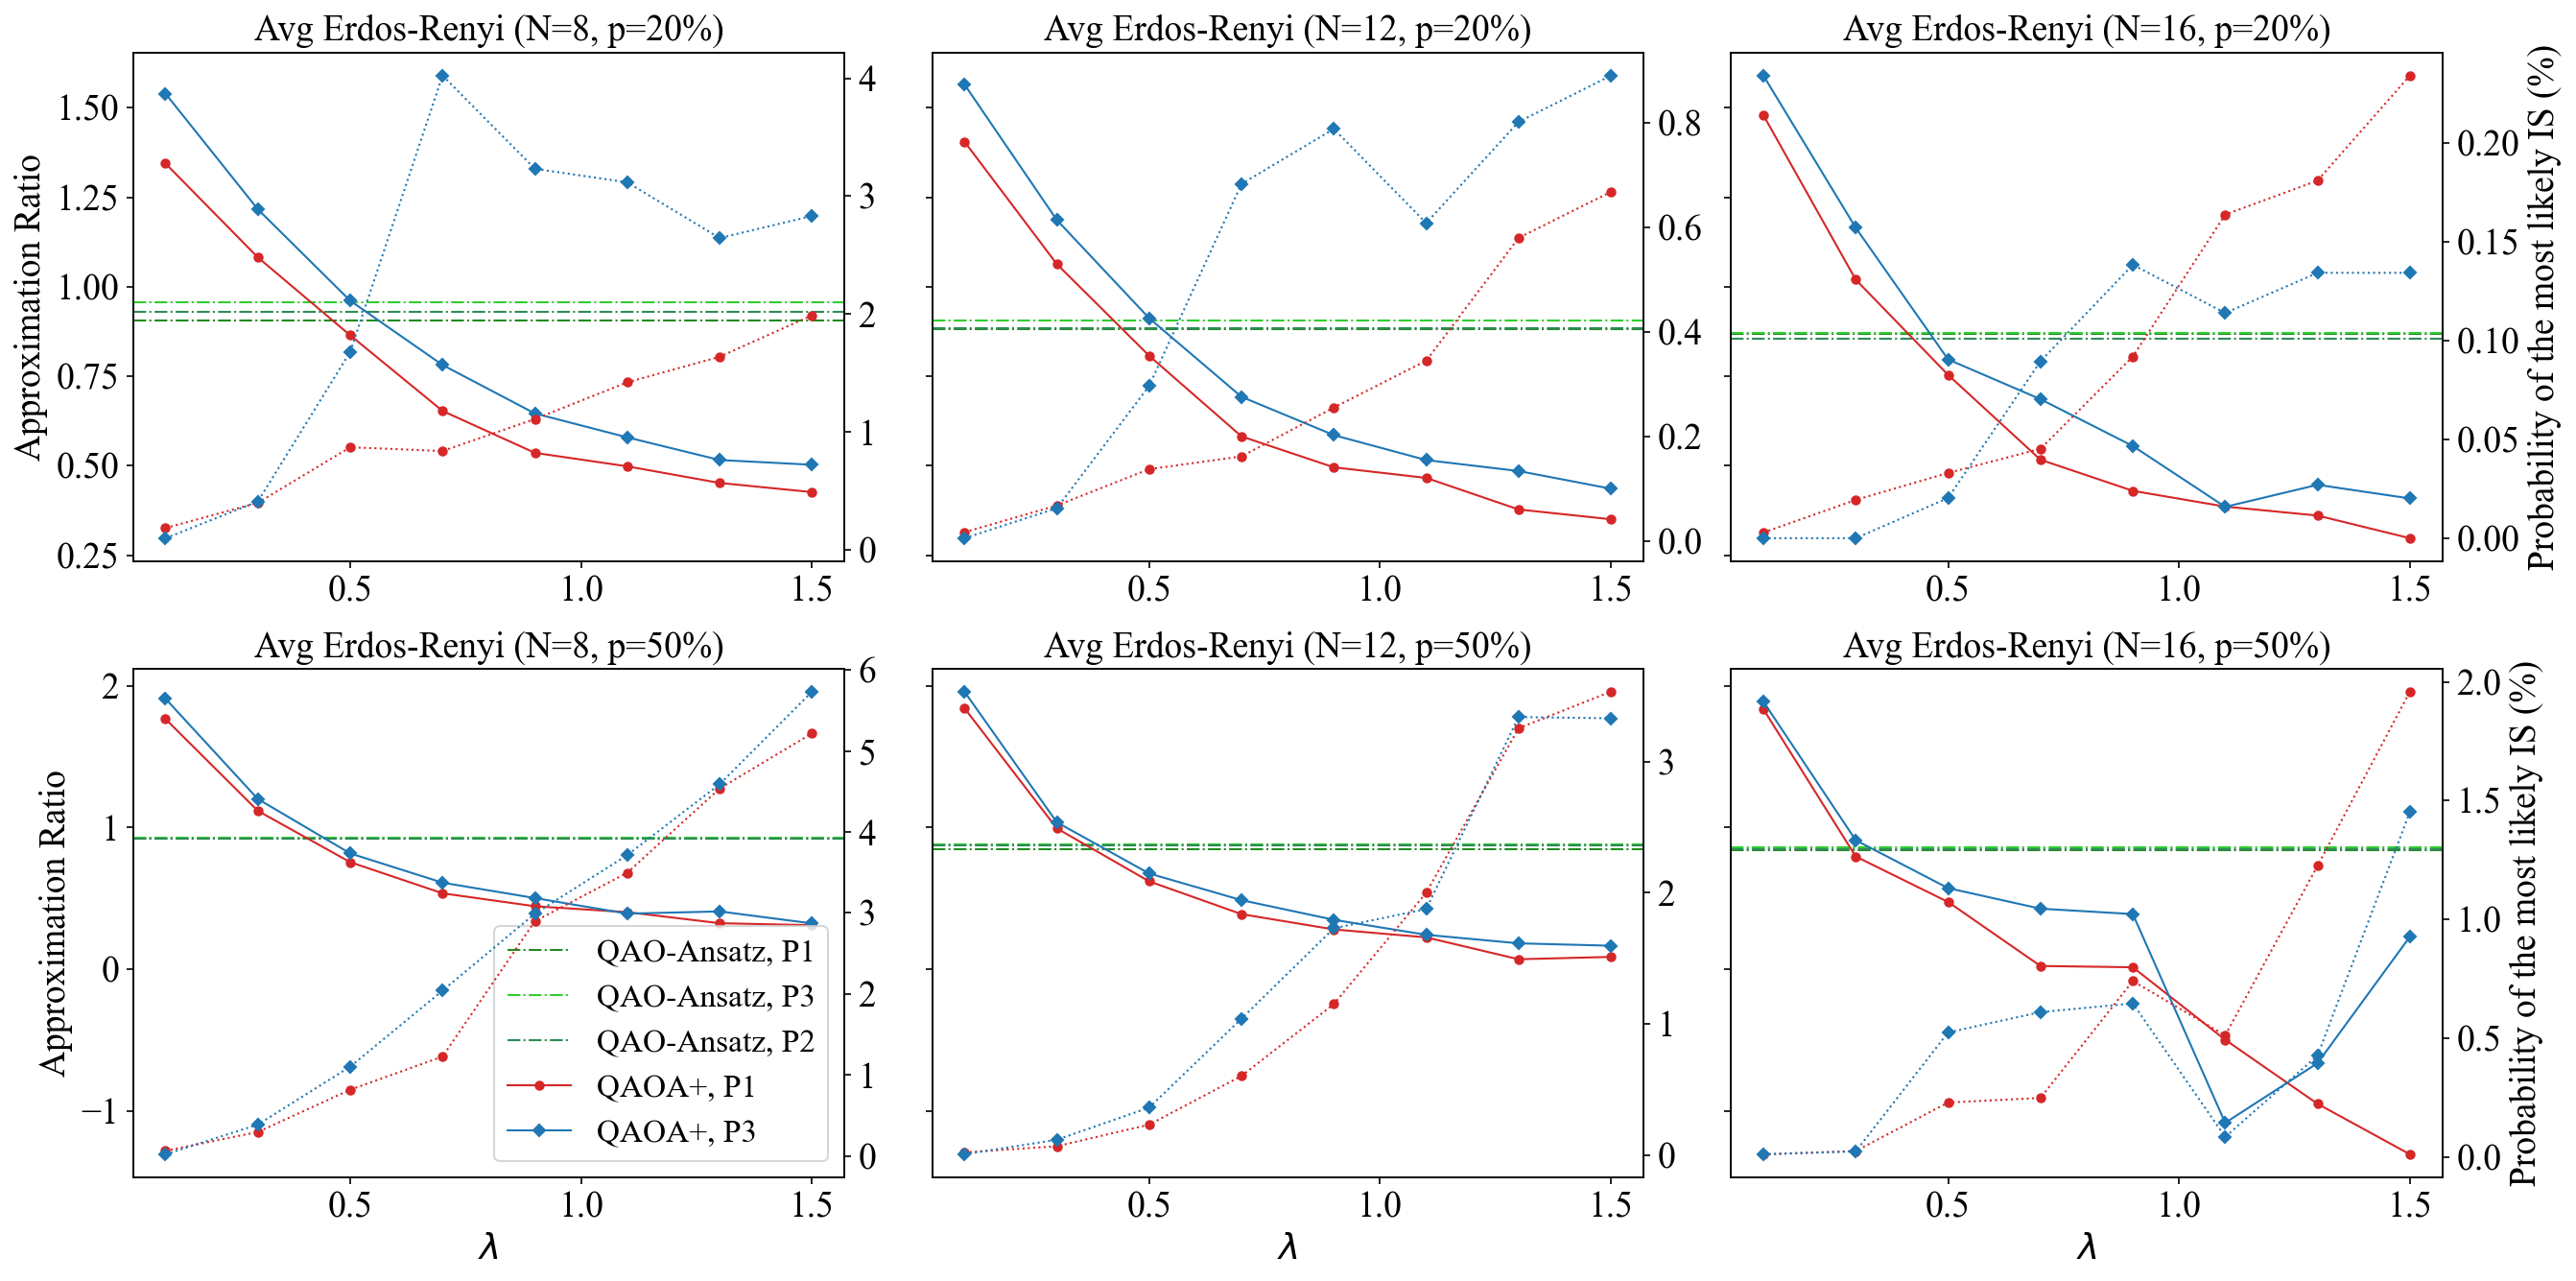

In [187]:
savestr = 'figures/combined_qaoa_plus.png'
#savestr = None
plot_comp_fig(figure_data, savestr=savestr)